# LSTM Model

This notebook is used to develop an LSTM model for predicting Dow Jones stocks.  

We will begin with the Walmart stock data as a beginning test.

### Packages

First, we load important packages.

In [1]:
#import some useful packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Data

Now, we can load the data.

In [2]:
#load Walmart Stock Data
filepath = os.path.join('..', 'Resources', 'WMT.csv')
df = pd.read_csv(filepath)
df.head()

,date,open,high,low,close,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
0,2014-01-27,64.7650,64.9747,64.5029,64.7825,9105139,9105139,-0.235889,-0.363,64.7739,"Jan 27, 14",0.000000
1,2014-01-28,64.8786,65.8746,64.7388,65.2368,6035231,6035231,0.454305,0.701,65.3045,"Jan 28, 14",0.007013
2,2014-01-29,65.7785,65.8484,64.7126,64.7388,8440854,8440854,-0.497990,-0.763,61.0517,"Jan 29, 14",-0.000675
3,2014-01-30,65.1232,65.6037,64.9660,65.3067,6742046,6742046,0.567883,0.877,65.2975,"Jan 30, 14",0.008092
4,2014-01-31,64.5816,65.6911,64.3369,65.2455,10665285,10665285,-0.061155,-0.094,65.3223,"Jan 31, 14",0.007147


We get rid of columns we do not need and set the index as the date column.

In [3]:
#drop unnessecary columns
df.drop(['volume', 'unadjustedVolume', 'change', 'changePercent', 'vwap', 'label', 'changeOverTime'], 1, inplace = True)
df.head()

,date,open,high,low,close
0,2014-01-27,64.7650,64.9747,64.5029,64.7825
1,2014-01-28,64.8786,65.8746,64.7388,65.2368
2,2014-01-29,65.7785,65.8484,64.7126,64.7388
3,2014-01-30,65.1232,65.6037,64.9660,65.3067
4,2014-01-31,64.5816,65.6911,64.3369,65.2455


In [4]:
#set index
df.set_index('date', inplace = True)
df.head()

,open,high,low,close
date,,,,
2014-01-27,64.7650,64.9747,64.5029,64.7825
2014-01-28,64.8786,65.8746,64.7388,65.2368
2014-01-29,65.7785,65.8484,64.7126,64.7388
2014-01-30,65.1232,65.6037,64.9660,65.3067
2014-01-31,64.5816,65.6911,64.3369,65.2455


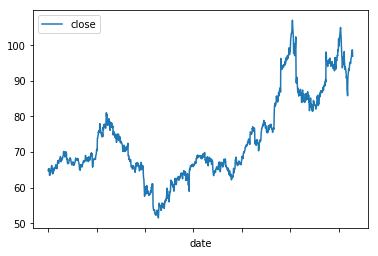

In [5]:
#plot close price
df.plot(y='close')

### Create Train and Test Split Data

We need to create a train/test split.  To do so, we will assume we feed sequences of some length and predict at some point in the future.

In [6]:
#save data as a matrix
data = df.values
data.shape

(1259, 4)

In [7]:
#save sequence length and time in the future
#we will start with 30 days and 5 days in the future (about 1 month and 1 week)
seq_length = 30
fut_point = 5
features = 4

In [8]:
#get X data (30 day sequences)
X = []
#get all sequences up to (sequence length + future point) days out of last point (can then predict last point)
for index in range(len(data) - seq_length - fut_point):
    X.append(data[index: index + seq_length])
#get X as a numpy array
X = np.array(X)
X.shape

(1224, 30, 4)

In [9]:
#get Y data (close price for all days except first (sequence length + future point) days)
y = data[(seq_length + fut_point):, -1]
y.shape

(1224,)

In [10]:
#train/test split of 0.85/0.15
train_split = 0.85
last_row = int(train_split * X.shape[0])
X_train = X[:last_row]
X_test = X[last_row:]
y_train = y[:last_row]
y_test = y[last_row:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1040, 30, 4)
(184, 30, 4)
(1040,)
(184,)


### Scale Data
We scale the data using the MinMaxScaler fit for the training data.

In [11]:
#instantiate scalers
X_scaler = MinMaxScaler(feature_range = (-1, 1))
y_scaler = MinMaxScaler(feature_range = (-1, 1))

In [12]:
#reshape data so it can be fit
X_train_reshaped = np.reshape(X_train, (-1, 4))
X_test_reshaped = np.reshape(X_test, (-1, 4))
y_train_reshaped = np.reshape(y_train, (-1, 1))
y_test_reshaped = np.reshape(y_test, (-1, 1))

In [13]:
#fit scalers
X_scaler.fit(X_train_reshaped)
y_scaler.fit(y_train_reshaped)

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [14]:
#transform and rescale
X_train_scaled = np.reshape(X_scaler.transform(X_train_reshaped), X_train.shape)
X_test_scaled = np.reshape(X_scaler.transform(X_test_reshaped), X_test.shape)
y_train_scaled = np.reshape(y_scaler.transform(y_train_reshaped), y_train.shape[0])
y_test_scaled = np.reshape(y_scaler.transform(y_test_reshaped), y_test.shape[0])
X_train_scaled.shape

(1040, 30, 4)

### LSTM model
Now, we build a basic LSTM network model.

We build several LSTM layers together, adding Dropout layers and a few dense layers to summarize.

In [15]:
#import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM

/anaconda3/envs/PythonData/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [37]:
#create an LSTM model
model = Sequential()

#add first LSTM layer and dropout layer
model.add(LSTM(256, return_sequences = True, input_shape = (seq_length, features)))
model.add(Dropout(0.2))

#add second LSTM layer and dropout layer
model.add(LSTM(256, return_sequences = False))
model.add(Dropout(0.2))

#add an reLU layer
model.add(Dense(32, activation = 'relu'))

#add a final layer
model.add(Dense(1, activation = 'linear'))

#compile model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 256)           267264    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 800,833
Trainable params: 800,833
Non-trainable params: 0
_________________________________________________________________


In [38]:
#fit model
model.fit(X_train_scaled, y_train_scaled, epochs = 300, batch_size = 64, validation_split = 0.15, verbose = 1)

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 3s 4ms/step - loss: 0.0414 - acc: 0.0011 - val_loss: 0.0694 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0087 - acc: 0.0011 - val_loss: 0.0662 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.0693 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.0780 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.0854 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0055 - acc: 0.0011 - val_loss: 0.0931 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.1094 - val_acc: 0.0000

884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1052 - val_acc: 0.0064
Epoch 120/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.0901 - val_acc: 0.0064
Epoch 121/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0713 - val_acc: 0.0064
Epoch 122/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0649 - val_acc: 0.0064
Epoch 123/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0667 - val_acc: 0.0064
Epoch 124/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.1345 - val_acc: 0.0064
Epoch 125/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0939 - val_acc: 0.0064
Epoch 126/300
884/884 [==============================] - 2s 2ms/step 

Epoch 180/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0740 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0413 - val_acc: 0.0064
Epoch 182/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0570 - val_acc: 0.0064
Epoch 183/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0992 - val_acc: 0.0064
Epoch 184/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0476 - val_acc: 0.0064
Epoch 185/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0413 - val_acc: 0.0064
Epoch 186/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 187/300
884/884 [============================

884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1371 - val_acc: 0.0064


In [39]:
model.save('first_model.h5')

### Load Model and Make Predictions

We load the model from memory.

In [16]:
model = load_model('first_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 256)           267264    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 800,833
Trainable params: 800,833
Non-trainable params: 0
_________________________________________________________________


Now we get the scores and root mean square errors.

In [17]:
#score models
import math
train_score = model.evaluate(X_train_scaled, y_train_scaled, verbose = 0)
test_score = model.evaluate(X_test_scaled, y_test_scaled, verbose = 0)
train_rmse = math.sqrt(train_score[0])
test_rmse = math.sqrt(test_score[0])
print(f"Training Set- Score: {train_score[0]}, RMSE: {train_rmse}")
print(f"Test Set- Score: {test_score[0]}, RMSE: {test_rmse}")

Training Set- Score: 0.02296979169343383, RMSE: 0.15155788232036574
Test Set- Score: 0.11483484830545343, RMSE: 0.3388729087806422


Now, we make predictions.

In [18]:
#evaluate model on training set and test set
y_train_preds_scaled = model.predict(X_train_scaled)
y_test_preds_scaled = model.predict(X_test_scaled)
y_train_preds_scaled.shape

(1040, 1)

### Plot results
We now wish to visualize our results.

First, we need to denormalize.

In [19]:
#rescale results
y_train_preds_denormed = y_scaler.inverse_transform(y_train_preds_scaled)
y_test_preds_denormed = y_scaler.inverse_transform(y_test_preds_scaled)

Now, we can reshape to the same shape as the training and test sets.

In [20]:
#reshape results for plotting
y_train_preds = np.reshape(y_train_preds_denormed, y_train.shape[0])
y_test_preds = np.reshape(y_test_preds_denormed, y_test.shape[0])
y_train_preds.shape

(1040,)

Now, we can plot the results.

In [21]:
#create x arrays (just day indices)
days1 = np.arange(len(y_train))
days2 = np.arange(len(y_train), len(y_train) + len(y_test))

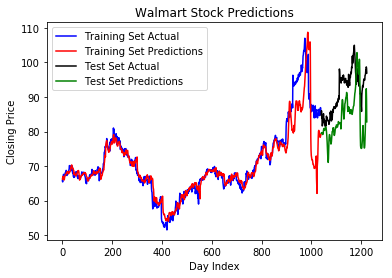

In [22]:
#plot
fig, ax = plt.subplots()
ax.plot(days1, y_train, 'b', label = 'Training Set Actual')
ax.plot(days1, y_train_preds, 'r', label = 'Training Set Predictions')
ax.plot(days2, y_test, 'k', label = 'Test Set Actual')
ax.plot(days2, y_test_preds, 'g', label = 'Test Set Predictions')
ax.legend()
ax.set_title('Walmart Stock Predictions')
ax.set_xlabel('Day Index')
ax.set_ylabel('Closing Price')
plt.show()

We can also plot only the test set.

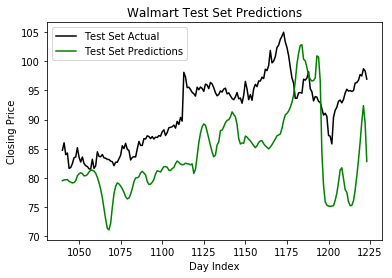

In [23]:
#plot test set only
fig2, ax2 = plt.subplots()
ax2.plot(days2, y_test, 'k', label = 'Test Set Actual')
ax2.plot(days2, y_test_preds, 'g', label = 'Test Set Predictions')
ax2.legend()
ax2.set_title('Walmart Test Set Predictions')
ax2.set_xlabel('Day Index')
ax2.set_ylabel('Closing Price')
plt.show()

### Functions for Arbitrary Size, Number of Neurons, and Future Time Point
We wish to create functions that allow for some more arbitrary settings.

In [17]:
#function to create training and test data from a dataframe
def train_test_splitter(df, seq_length, fut_point, train_split):
    #save data as a matrix
    data = df.values
    
    #save number of features
    features = data.shape[1]
    
    #get X data (30 day sequences)
    X = []
    #get all sequences up to (sequence length + future point) days out of last point (can then predict last point)
    for index in range(len(data) - seq_length - fut_point):
        X.append(data[index: index + seq_length])
    #get X as a numpy array
    X = np.array(X)
    
    #get Y data (close price for all days except first (sequence length + future point) days)
    y = data[(seq_length + fut_point):, -1]
    
    #create train/test splits using chosing training split (between 0 and 1)
    last_row = int(train_split * X.shape[0])
    X_train = X[:last_row]
    X_test = X[last_row:]
    y_train = y[:last_row]
    y_test = y[last_row:]
    return X_train, X_test, y_train, y_test

In [25]:
#test function with 180 days sequence and 80 days future point
X_train2, X_test2, y_train2, y_test2 = train_test_splitter(df, 180, 80, 0.85)

In [18]:
#function to create scaled data and scalers
def create_scalers_and_normalize(X_train, X_test, y_train, y_test):
    #instantiate scalers
    X_scaler = MinMaxScaler(feature_range = (-1, 1))
    y_scaler = MinMaxScaler(feature_range = (-1, 1))
    
    #get number of features
    features = X_train.shape[2]
    
    #reshape data so it can be fit
    X_train_reshaped = np.reshape(X_train, (-1, features))
    X_test_reshaped = np.reshape(X_test, (-1, features))
    y_train_reshaped = np.reshape(y_train, (-1, 1))
    y_test_reshaped = np.reshape(y_test, (-1, 1))
    
    #fit scalers
    X_scaler.fit(X_train_reshaped)
    y_scaler.fit(y_train_reshaped)
    
    #transform and rescale
    X_train_scaled = np.reshape(X_scaler.transform(X_train_reshaped), X_train.shape)
    X_test_scaled = np.reshape(X_scaler.transform(X_test_reshaped), X_test.shape)
    y_train_scaled = np.reshape(y_scaler.transform(y_train_reshaped), y_train.shape[0])
    y_test_scaled = np.reshape(y_scaler.transform(y_test_reshaped), y_test.shape[0])
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler

In [27]:
X_train_scaled2, X_test_scaled2, y_train_scaled2, y_test_scaled2, X_scaler2, y_scaler2 = create_scalers_and_normalize(
    X_train2, X_test2, y_train2, y_test2)

In [19]:
#create an LSTM model with different neuron sizes
def create_generic_LSTM_model(neurons, dropout, seq_length, features):
    #create an LSTM model
    model = Sequential()

    #add first LSTM layer and dropout layer
    model.add(LSTM(neurons[0], return_sequences = True, input_shape = (seq_length, features)))
    model.add(Dropout(0.2))

    #add second LSTM layer and dropout layer
    model.add(LSTM(neurons[1], return_sequences = False))
    model.add(Dropout(0.2))

    #add an reLU layer
    model.add(Dense(neurons[2], activation = 'relu'))

    #add a final layer
    model.add(Dense(1, activation = 'linear'))

    #compile model
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [29]:
#test function
new_model = create_generic_LSTM_model([256, 256, 32], 0.2, 180, 4)

In [60]:
#save model
new_model.save('second_model.h5')

In [30]:
#load model
new_model = load_model('second_model.h5')

In [20]:
#function to evaluate score and return predictions for a given model path
import math
def make_preds(model_path, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler):
    #load model
    model = load_model(model_path)
    
    #score models
    train_score = model.evaluate(X_train_scaled, y_train_scaled, verbose = 0)
    test_score = model.evaluate(X_test_scaled, y_test_scaled, verbose = 0)
    train_rmse = math.sqrt(train_score[0])
    test_rmse = math.sqrt(test_score[0])
    print(f"Training Set- Score: {train_score[0]}, RMSE: {train_rmse}")
    print(f"Test Set- Score: {test_score[0]}, RMSE: {test_rmse}")
    
    #evaluate model on training set and test set
    y_train_preds_scaled = model.predict(X_train_scaled)
    y_test_preds_scaled = model.predict(X_test_scaled)
    
    #rescale results
    y_train_preds_denormed = y_scaler.inverse_transform(y_train_preds_scaled)
    y_test_preds_denormed = y_scaler.inverse_transform(y_test_preds_scaled)
    
    #reshape results for plotting
    y_train_preds = np.reshape(y_train_preds_denormed, len(y_train_scaled))
    y_test_preds = np.reshape(y_test_preds_denormed, len(y_test_scaled))
    
    return y_train_preds, y_test_preds, train_score, test_score

In [32]:
#test function
y_train_preds, y_test_preds, train_score, test_score =  make_preds('first_model.h5', X_train_scaled, 
                                                                   X_test_scaled, y_train_scaled, y_test_scaled, 
                                                                   y_scaler)

Training Set- Score: 0.02296979169343383, RMSE: 0.15155788232036574
Test Set- Score: 0.11483484830545343, RMSE: 0.3388729087806422


In [21]:
#function to create, compile, fit a model, and make predictions
def fit_generic_LSTM_model(df, seq_length, fut_point, train_split, neurons, dropout, epochs, batch_size, 
                           validation_split, model_path):
    
    #get train/test split
    X_train, X_test, y_train, y_test = train_test_splitter(df, seq_length, fut_point, train_split)
    
    #get number of features
    features = X_train.shape[2]
    
    #get scalers and normalized data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler = create_scalers_and_normalize(
        X_train, X_test, y_train, y_test)
    
    #create model
    model = create_generic_LSTM_model(neurons, dropout, seq_length, features)
    
    #fit model
    model.fit(X_train_scaled, y_train_scaled, epochs = epochs, 
              batch_size = batch_size, validation_split = validation_split, verbose = 1)
    
    #save model
    model.save(model_path)
    
    #evaluate model and get predictions
    y_train_preds, y_test_preds, train_score, test_score = make_preds(model_path, 
                                                                      X_train_scaled, X_test_scaled, 
                                                                      y_train_scaled, y_test_scaled, y_scaler)
    
    #return necessary variables to create predictions
    return y_train, y_test, y_train_preds, y_test_preds, train_score, test_score

In [49]:
#test function
seq_length = 180
fut_point = 80
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'third_model.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 721 samples, validate on 128 samples
Epoch 1/300
721/721 [==============================] - 13s 18ms/step - loss: 0.1062 - acc: 0.0000e+00 - val_loss: 0.2903 - val_acc: 0.0000e+00
Epoch 2/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0737 - acc: 0.0000e+00 - val_loss: 0.3066 - val_acc: 0.0000e+00
Epoch 3/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0733 - acc: 0.0000e+00 - val_loss: 0.2910 - val_acc: 0.0000e+00
Epoch 4/300
721/721 [==============================] - 10s 13ms/step - loss: 0.0699 - acc: 0.0000e+00 - val_loss: 0.2854 - val_acc: 0.0000e+00
Epoch 5/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0704 - acc: 0.0000e+00 - val_loss: 0.3028 - val_acc: 0.0000e+00
Epoch 6/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0708 - acc: 0.0000e+00 - val_loss: 0.2989 - val_acc: 0.0000e+00
Epoch 7/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0703 - acc: 0.0000e+00

721/721 [==============================] - 9s 12ms/step - loss: 0.0332 - acc: 0.0014 - val_loss: 1.6586 - val_acc: 0.0000e+00
Epoch 117/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0291 - acc: 0.0014 - val_loss: 2.0963 - val_acc: 0.0000e+00
Epoch 118/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0283 - acc: 0.0014 - val_loss: 2.2332 - val_acc: 0.0000e+00
Epoch 119/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0262 - acc: 0.0014 - val_loss: 2.7511 - val_acc: 0.0000e+00
Epoch 120/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0217 - acc: 0.0014 - val_loss: 2.3657 - val_acc: 0.0000e+00
Epoch 121/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0336 - acc: 0.0014 - val_loss: 1.4498 - val_acc: 0.0000e+00
Epoch 122/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0273 - acc: 0.0014 - val_loss: 0.9754 - val_acc: 0.0000e+00
Epoch 123/300
721/721 [===========

721/721 [==============================] - 9s 13ms/step - loss: 0.0223 - acc: 0.0014 - val_loss: 0.5446 - val_acc: 0.0000e+00
Epoch 232/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0261 - acc: 0.0014 - val_loss: 0.6807 - val_acc: 0.0000e+00
Epoch 233/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0228 - acc: 0.0014 - val_loss: 0.6310 - val_acc: 0.0000e+00
Epoch 234/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0218 - acc: 0.0014 - val_loss: 0.6779 - val_acc: 0.0000e+00
Epoch 235/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0238 - acc: 0.0014 - val_loss: 0.6438 - val_acc: 0.0000e+00
Epoch 236/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0231 - acc: 0.0014 - val_loss: 0.5744 - val_acc: 0.0000e+00
Epoch 237/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0212 - acc: 0.0014 - val_loss: 0.6059 - val_acc: 0.0000e+00
Epoch 238/300
721/721 [===========

In [26]:
#function to plot results
def make_results_plot(y_train, y_test, y_train_preds, y_test_preds):
    #create x arrays (just day indices)
    days1 = np.arange(len(y_train))
    days2 = np.arange(len(y_train), len(y_train) + len(y_test))
    
    #plot
    fig, ax = plt.subplots()
    ax.plot(days1, y_train, 'b', label = 'Training Set Actual')
    ax.plot(days1, y_train_preds, 'r', label = 'Training Set Predictions')
    ax.plot(days2, y_test, 'k', label = 'Test Set Actual')
    ax.plot(days2, y_test_preds, 'g', label = 'Test Set Predictions')
    ax.legend()
    ax.set_title('Walmart Stock Predictions')
    ax.set_xlabel('Day Index')
    ax.set_ylabel('Closing Price')
    plt.show()

Training Set- Score: 0.10574903501498265, RMSE: 0.3251907671121409
Test Set- Score: 1.2414444414774577, RMSE: 1.1142012571692144


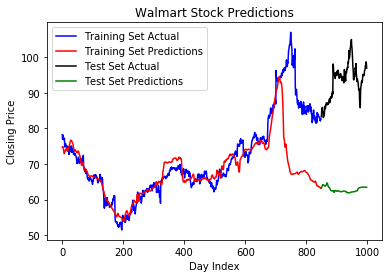

In [50]:
#test function
y_train_preds3, y_test_preds3, train_score3, test_score3 = make_preds('third_model.h5', 
                                                                                         X_train_scaled2, 
                                                                                         X_test_scaled2, 
                                                                                         y_train_scaled2, 
                                                                                         y_test_scaled2, y_scaler2)
make_results_plot(y_train2, y_test2, y_train_preds3, y_test_preds3)

### Time Interval Testing

One day future point, 20 days past information.

In [44]:
#test function
seq_length = 20
fut_point = 1
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'first_one_day_model.h5'
y_train5, y_test5, y_train_preds5, y_test_preds5, train_score5, test_score5 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 894 samples, validate on 158 samples
Epoch 1/300
894/894 [==============================] - 5s 5ms/step - loss: 0.0366 - acc: 0.0011 - val_loss: 0.0968 - val_acc: 0.0000e+00
Epoch 2/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.1045 - val_acc: 0.0000e+00
Epoch 3/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.1149 - val_acc: 0.0000e+00
Epoch 4/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.1241 - val_acc: 0.0000e+00
Epoch 5/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.1377 - val_acc: 0.0000e+00
Epoch 6/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1550 - val_acc: 0.0000e+00
Epoch 7/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.1724 - val_acc: 0.0000

894/894 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.2754 - val_acc: 0.0000e+00
Epoch 120/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.2672 - val_acc: 0.0000e+00
Epoch 121/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.2390 - val_acc: 0.0000e+00
Epoch 122/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.2852 - val_acc: 0.0000e+00
Epoch 123/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.2511 - val_acc: 0.0000e+00
Epoch 124/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.2515 - val_acc: 0.0000e+00
Epoch 125/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.2461 - val_acc: 0.0000e+00
Epoch 126/300
894/894 [==================

894/894 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1445 - val_acc: 0.0000e+00
Epoch 179/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.1376 - val_acc: 0.0000e+00
Epoch 180/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1300 - val_acc: 0.0000e+00
Epoch 181/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1473 - val_acc: 0.0000e+00
Epoch 182/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.1574 - val_acc: 0.0000e+00
Epoch 183/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1648 - val_acc: 0.0000e+00
Epoch 184/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.1550 - val_acc: 0.0000e+00
Epoch 185/300
894/894 [==================

894/894 [==============================] - 1s 2ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1067 - val_acc: 0.0000e+00
Epoch 238/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.0969 - val_acc: 0.0000e+00
Epoch 239/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1140 - val_acc: 0.0000e+00
Epoch 240/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1126 - val_acc: 0.0000e+00
Epoch 241/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1298 - val_acc: 0.0000e+00
Epoch 242/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1058 - val_acc: 0.0000e+00
Epoch 243/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.0717 - val_acc: 0.0000e+00
Epoch 244/300
894/894 [==================

894/894 [==============================] - 1s 2ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0728 - val_acc: 0.0000e+00
Epoch 297/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.1354 - val_acc: 0.0000e+00
Epoch 298/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0014 - acc: 0.0011 - val_loss: 0.1337 - val_acc: 0.0000e+00
Epoch 299/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0858 - val_acc: 0.0000e+00
Epoch 300/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.1130 - val_acc: 0.0000e+00
Training Set- Score: 0.018251367610925277, RMSE: 0.13509762252136517
Test Set- Score: 0.12118753662673376, RMSE: 0.3481200031982273


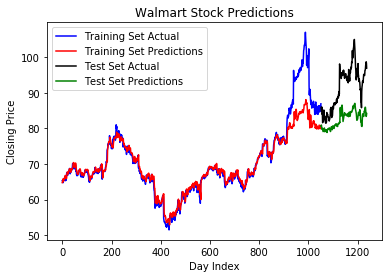

In [45]:
#plot
make_results_plot(y_train5, y_test5, y_train_preds5, y_test_preds5)

Now, we try even lengths:  20 days and 20 days.

In [46]:
#test function
seq_length = 20
fut_point = 20
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'four_week_model.h5'
y_train6, y_test6, y_train_preds6, y_test_preds6, train_score6, test_score6 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 880 samples, validate on 156 samples
Epoch 1/300
880/880 [==============================] - 5s 6ms/step - loss: 0.0563 - acc: 0.0011 - val_loss: 0.1201 - val_acc: 0.0000e+00
Epoch 2/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0185 - acc: 0.0011 - val_loss: 0.1179 - val_acc: 0.0000e+00
Epoch 3/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0151 - acc: 0.0011 - val_loss: 0.1187 - val_acc: 0.0000e+00
Epoch 4/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0146 - acc: 0.0011 - val_loss: 0.1229 - val_acc: 0.0000e+00
Epoch 5/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0138 - acc: 0.0011 - val_loss: 0.1277 - val_acc: 0.0000e+00
Epoch 6/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0133 - acc: 0.0011 - val_loss: 0.1313 - val_acc: 0.0000e+00
Epoch 7/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0130 - acc: 0.0011 - val_loss: 0.1329 - val_acc: 0.0000

880/880 [==============================] - 1s 2ms/step - loss: 0.0115 - acc: 0.0011 - val_loss: 0.7397 - val_acc: 0.0000e+00
Epoch 120/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0118 - acc: 0.0011 - val_loss: 2.0087 - val_acc: 0.0000e+00
Epoch 121/300
880/880 [==============================] - 1s 2ms/step - loss: 0.0113 - acc: 0.0011 - val_loss: 1.4404 - val_acc: 0.0000e+00
Epoch 122/300
880/880 [==============================] - 1s 2ms/step - loss: 0.0112 - acc: 0.0011 - val_loss: 0.6584 - val_acc: 0.0000e+00
Epoch 123/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0113 - acc: 0.0011 - val_loss: 0.7111 - val_acc: 0.0000e+00
Epoch 124/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0113 - acc: 0.0011 - val_loss: 0.5468 - val_acc: 0.0000e+00
Epoch 125/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0117 - acc: 0.0011 - val_loss: 0.4080 - val_acc: 0.0000e+00
Epoch 126/300
880/880 [==================

880/880 [==============================] - 1s 1ms/step - loss: 0.0093 - acc: 0.0011 - val_loss: 0.2128 - val_acc: 0.0000e+00
Epoch 238/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0098 - acc: 0.0011 - val_loss: 0.2566 - val_acc: 0.0000e+00
Epoch 239/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0096 - acc: 0.0011 - val_loss: 0.1281 - val_acc: 0.0000e+00
Epoch 240/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0097 - acc: 0.0011 - val_loss: 0.1606 - val_acc: 0.0000e+00
Epoch 241/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0105 - acc: 0.0011 - val_loss: 0.2864 - val_acc: 0.0000e+00
Epoch 242/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0106 - acc: 0.0011 - val_loss: 0.3259 - val_acc: 0.0000e+00
Epoch 243/300
880/880 [==============================] - 1s 2ms/step - loss: 0.0095 - acc: 0.0011 - val_loss: 0.1869 - val_acc: 0.0000e+00
Epoch 244/300
880/880 [==================

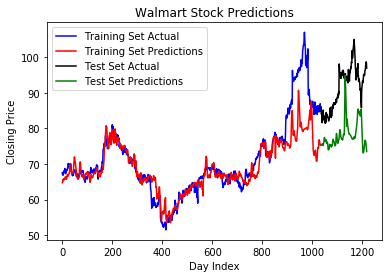

In [47]:
#plot
make_results_plot(y_train6, y_test6, y_train_preds6, y_test_preds6)

In [42]:
#predict one day ahead with last week's data
seq_length = 5
fut_point = 1
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'one_day_model.h5'
y_train4, y_test4, y_train_preds4, y_test_preds4, train_score4, test_score4 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 905 samples, validate on 160 samples
Epoch 1/300
905/905 [==============================] - 3s 4ms/step - loss: 0.0426 - acc: 0.0011 - val_loss: 0.1358 - val_acc: 0.0000e+00
Epoch 2/300
905/905 [==============================] - 0s 476us/step - loss: 0.0057 - acc: 0.0011 - val_loss: 0.1239 - val_acc: 0.0000e+00
Epoch 3/300
905/905 [==============================] - 1s 622us/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.1176 - val_acc: 0.0000e+00
Epoch 4/300
905/905 [==============================] - 0s 516us/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1146 - val_acc: 0.0000e+00
Epoch 5/300
905/905 [==============================] - 1s 598us/step - loss: 0.0028 - acc: 0.0011 - val_loss: 0.1163 - val_acc: 0.0000e+00
Epoch 6/300
905/905 [==============================] - 0s 526us/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.1206 - val_acc: 0.0000e+00
Epoch 7/300
905/905 [==============================] - 1s 718us/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.1256 - val

905/905 [==============================] - 0s 551us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1440 - val_acc: 0.0000e+00
Epoch 118/300
905/905 [==============================] - 1s 575us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1250 - val_acc: 0.0000e+00
Epoch 119/300
905/905 [==============================] - 1s 573us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1399 - val_acc: 0.0000e+00
Epoch 120/300
905/905 [==============================] - 0s 534us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1327 - val_acc: 0.0000e+00
Epoch 121/300
905/905 [==============================] - 0s 547us/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1564 - val_acc: 0.0000e+00
Epoch 122/300
905/905 [==============================] - 0s 547us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1546 - val_acc: 0.0000e+00
Epoch 123/300
905/905 [==============================] - 0s 549us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1390 - val_acc: 0.0000e+00
Epoch 124/300
905/905 [====

905/905 [==============================] - 0s 461us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1545 - val_acc: 0.0000e+00
Epoch 234/300
905/905 [==============================] - 0s 452us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1401 - val_acc: 0.0000e+00
Epoch 235/300
905/905 [==============================] - 0s 474us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1210 - val_acc: 0.0000e+00
Epoch 236/300
905/905 [==============================] - 1s 680us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1137 - val_acc: 0.0000e+00
Epoch 237/300
905/905 [==============================] - 1s 847us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1885 - val_acc: 0.0000e+00
Epoch 238/300
905/905 [==============================] - 1s 587us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1662 - val_acc: 0.0000e+00
Epoch 239/300
905/905 [==============================] - 0s 475us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1501 - val_acc: 0.0000e+00
Epoch 240/300
905/905 [====

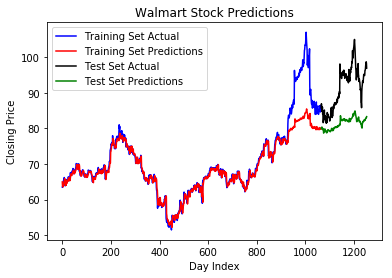

In [43]:
#plot
make_results_plot(y_train4, y_test4, y_train_preds4, y_test_preds4)

### Try different numbers of features

We will read in the dataframe again and consider another couple features (volume traded and vwap).

We test compared to the first model.

In [52]:
#load Walmart Stock Data
filepath = os.path.join('..', 'Resources', 'WMT.csv')
new_df = pd.read_csv(filepath)

#drop unnessecary columns
new_df.drop(['unadjustedVolume', 'change', 'changePercent', 'label', 'changeOverTime'], 1, inplace = True)

#set index
new_df.set_index('date', inplace = True)
new_df.head()

,open,high,low,close,volume,vwap
date,,,,,,
2014-01-27,64.7650,64.9747,64.5029,64.7825,9105139,64.7739
2014-01-28,64.8786,65.8746,64.7388,65.2368,6035231,65.3045
2014-01-29,65.7785,65.8484,64.7126,64.7388,8440854,61.0517
2014-01-30,65.1232,65.6037,64.9660,65.3067,6742046,65.2975
2014-01-31,64.5816,65.6911,64.3369,65.2455,10665285,65.3223


We will first run the functions for 30 days sequence and 5 days of future point for the old number of features.

In [53]:
#model for old number of features
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'more_features.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 7s 8ms/step - loss: 0.0480 - acc: 0.0011 - val_loss: 0.0932 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0094 - acc: 0.0011 - val_loss: 0.1219 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0068 - acc: 0.0011 - val_loss: 0.1185 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.1181 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0058 - acc: 0.0011 - val_loss: 0.1282 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1383 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.1467 - val_acc: 0.0000

884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.1146 - val_acc: 0.0064
Epoch 121/300
884/884 [==============================] - 3s 3ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0364 - val_acc: 0.0064
Epoch 122/300
884/884 [==============================] - 3s 3ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.1258 - val_acc: 0.0064
Epoch 123/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1360 - val_acc: 0.0064
Epoch 124/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1143 - val_acc: 0.0064
Epoch 125/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0398 - val_acc: 0.0064
Epoch 126/300
884/884 [==============================] - 2s 3ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0347 - val_acc: 0.0064
Epoch 127/300
884/884 [==============================] - 3s 3ms/step 

Epoch 241/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0338 - val_acc: 0.0064
Epoch 242/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0260 - val_acc: 0.0064
Epoch 243/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0445 - val_acc: 0.0000e+00
Epoch 244/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0255 - val_acc: 0.0064
Epoch 245/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0386 - val_acc: 0.0064
Epoch 246/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0371 - val_acc: 0.0064
Epoch 247/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0348 - val_acc: 0.0064
Epoch 248/300
884/884 [============================

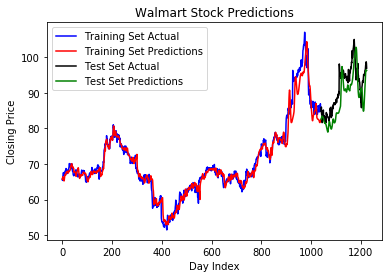

In [54]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

In [59]:
#model for new number of features
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'more_features_real_long.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(new_df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 8s 9ms/step - loss: 0.0548 - acc: 0.0011 - val_loss: 0.1058 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0092 - acc: 0.0011 - val_loss: 0.1263 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.1511 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.1673 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0059 - acc: 0.0011 - val_loss: 0.1731 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1909 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0052 - acc: 0.0011 - val_loss: 0.1707 - val_acc: 0.0000

884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1155 - val_acc: 0.0000e+00
Epoch 120/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.1431 - val_acc: 0.0000e+00
Epoch 121/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.1019 - val_acc: 0.0000e+00
Epoch 122/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1450 - val_acc: 0.0000e+00
Epoch 123/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0762 - val_acc: 0.0000e+00
Epoch 124/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0607 - val_acc: 0.0064
Epoch 125/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1088 - val_acc: 0.0000e+00
Epoch 126/300
884/884 [======================

Epoch 179/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0548 - val_acc: 0.0064
Epoch 180/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0374 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0649 - val_acc: 0.0064
Epoch 182/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0442 - val_acc: 0.0064
Epoch 183/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0468 - val_acc: 0.0064
Epoch 184/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0424 - val_acc: 0.0064
Epoch 185/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0391 - val_acc: 0.0064
Epoch 186/300
884/884 [==============================] 

Epoch 299/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0025 - acc: 0.0011 - val_loss: 0.0915 - val_acc: 0.0000e+00
Epoch 300/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0022 - acc: 0.0011 - val_loss: 0.0453 - val_acc: 0.0064
Training Set- Score: 0.008340317677133358, RMSE: 0.09132533973182556
Test Set- Score: 0.04561135691145192, RMSE: 0.2135681551904495


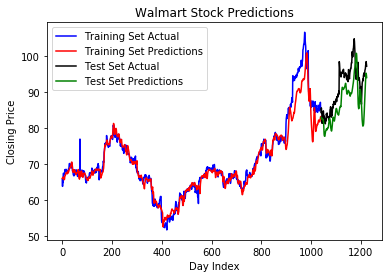

In [60]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

In [57]:
#test with 5 days sequence 1 day future point
seq_length = 5
fut_point = 1
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'more_features_real.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(new_df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 905 samples, validate on 160 samples
Epoch 1/300
905/905 [==============================] - 6s 7ms/step - loss: 0.0509 - acc: 0.0011 - val_loss: 0.1171 - val_acc: 0.0000e+00
Epoch 2/300
905/905 [==============================] - 0s 541us/step - loss: 0.0060 - acc: 0.0011 - val_loss: 0.1151 - val_acc: 0.0000e+00
Epoch 3/300
905/905 [==============================] - 1s 574us/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1254 - val_acc: 0.0000e+00
Epoch 4/300
905/905 [==============================] - 1s 553us/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1274 - val_acc: 0.0000e+00
Epoch 5/300
905/905 [==============================] - 1s 578us/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1339 - val_acc: 0.0000e+00
Epoch 6/300
905/905 [==============================] - 1s 554us/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.1376 - val_acc: 0.0000e+00
Epoch 7/300
905/905 [==============================] - 1s 581us/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.1406 - val

905/905 [==============================] - 1s 629us/step - loss: 0.0020 - acc: 0.0011 - val_loss: 0.1621 - val_acc: 0.0000e+00
Epoch 118/300
905/905 [==============================] - 1s 583us/step - loss: 0.0020 - acc: 0.0011 - val_loss: 0.1225 - val_acc: 0.0000e+00
Epoch 119/300
905/905 [==============================] - 1s 594us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.0879 - val_acc: 0.0000e+00
Epoch 120/300
905/905 [==============================] - 1s 584us/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1197 - val_acc: 0.0000e+00
Epoch 121/300
905/905 [==============================] - 1s 595us/step - loss: 0.0019 - acc: 0.0011 - val_loss: 0.0508 - val_acc: 0.0000e+00
Epoch 122/300
905/905 [==============================] - 1s 602us/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1184 - val_acc: 0.0000e+00
Epoch 123/300
905/905 [==============================] - 1s 574us/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1145 - val_acc: 0.0000e+00
Epoch 124/300
905/905 [====

905/905 [==============================] - 0s 548us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1260 - val_acc: 0.0000e+00
Epoch 234/300
905/905 [==============================] - 0s 547us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1448 - val_acc: 0.0000e+00
Epoch 235/300
905/905 [==============================] - 0s 538us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1373 - val_acc: 0.0000e+00
Epoch 236/300
905/905 [==============================] - 0s 537us/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1491 - val_acc: 0.0000e+00
Epoch 237/300
905/905 [==============================] - 0s 552us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1414 - val_acc: 0.0000e+00
Epoch 238/300
905/905 [==============================] - 0s 540us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1378 - val_acc: 0.0000e+00
Epoch 239/300
905/905 [==============================] - 0s 549us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1252 - val_acc: 0.0000e+00
Epoch 240/300
905/905 [====

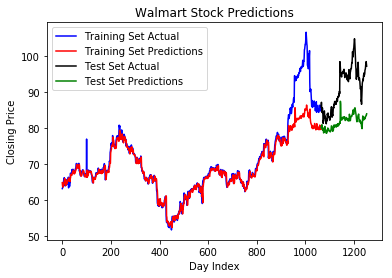

In [58]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

### Hyperparameter Tuning
Now, we attempt to tune hyperparameters of the model.

First, we will look at number of neurons.  For all of these first trials, we will use a sequence length of thirty 
and a future point of five.

In [22]:
#look at number of neurons
#use training score as metric (should really only score on test set when done.)
#set up parameters
seq_length = 30
fut_point = 5
train_split = 0.85
#neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'dummy_path.h5'

#set up variances of neuron size
neuron_lengths = [[256, 256, 32], [256, 256, 16], [128, 128, 32], [128, 128, 16], [64, 64, 32], [64, 64, 16]]

#create lists to store results
neurons = []
train_scores = []

#iterate
for neuron_length in neuron_lengths:
    neurons.append(f"{neuron_length}")
    
    train, test, train_preds, test_preds, train_score, test_score = fit_generic_LSTM_model(df, seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neuron_length, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)
    
    train_scores.append(train_score)
    
#create dataframe
results = pd.DataFrame({'Neuron Lengths': neurons, 'Train Scores': train_scores})

results.plot.bar(x = 'Neuron Lengths', y = 'Train Scores')

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 3s 4ms/step - loss: 0.0405 - acc: 0.0000e+00 - val_loss: 0.1296 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0068 - acc: 0.0011 - val_loss: 0.1641 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0058 - acc: 0.0011 - val_loss: 0.1728 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.1824 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.1828 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1783 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.1677 - val_acc: 0.

884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.2896 - val_acc: 0.0000e+00
Epoch 61/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.2654 - val_acc: 0.0000e+00
Epoch 62/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.2540 - val_acc: 0.0000e+00
Epoch 63/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.2687 - val_acc: 0.0000e+00
Epoch 64/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.2304 - val_acc: 0.0000e+00
Epoch 65/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.2343 - val_acc: 0.0000e+00
Epoch 66/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1899 - val_acc: 0.0000e+00
Epoch 67/300
884/884 [=========================

884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0400 - val_acc: 0.0064
Epoch 121/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0999 - val_acc: 0.0000e+00
Epoch 122/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0802 - val_acc: 0.0064
Epoch 123/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0692 - val_acc: 0.0064
Epoch 124/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0383 - val_acc: 0.0064
Epoch 125/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0828 - val_acc: 0.0064
Epoch 126/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0396 - val_acc: 0.0064
Epoch 127/300
884/884 [==============================] - 2s 2ms/s

884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0653 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0791 - val_acc: 0.0064
Epoch 182/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0700 - val_acc: 0.0064
Epoch 183/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0587 - val_acc: 0.0064
Epoch 184/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0571 - val_acc: 0.0064
Epoch 185/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0521 - val_acc: 0.0064
Epoch 186/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0602 - val_acc: 0.0064
Epoch 187/300
884/884 [==============================] - 2s 2ms/step 

884/884 [==============================] - 2s 2ms/step - loss: 0.0028 - acc: 0.0011 - val_loss: 0.0671 - val_acc: 0.0000e+00
Epoch 241/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.0603 - val_acc: 0.0000e+00
Epoch 242/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0384 - val_acc: 0.0000e+00
Epoch 243/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.0676 - val_acc: 0.0000e+00
Epoch 244/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.0242 - val_acc: 0.0064
Epoch 245/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0028 - acc: 0.0011 - val_loss: 0.0961 - val_acc: 0.0000e+00
Epoch 246/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1050 - val_acc: 0.0000e+00
Epoch 247/300
884/884 [======================

884/884 [==============================] - 2s 2ms/step - loss: 0.0026 - acc: 0.0011 - val_loss: 0.0382 - val_acc: 0.0064
Epoch 300/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0026 - acc: 0.0011 - val_loss: 0.0627 - val_acc: 0.0000e+00
Training Set- Score: 0.011277323450821523, RMSE: 0.10619474304701491
Test Set- Score: 0.06465379343084666, RMSE: 0.25427110223312177
Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 3s 4ms/step - loss: 0.0320 - acc: 0.0011 - val_loss: 0.1392 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0085 - acc: 0.0011 - val_loss: 0.1570 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.1729 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1781 - val_acc: 0.0000e+00
Epoch 5/300
8

884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.3446 - val_acc: 0.0000e+00
Epoch 58/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.3203 - val_acc: 0.0000e+00
Epoch 59/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.2964 - val_acc: 0.0000e+00
Epoch 60/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.3036 - val_acc: 0.0000e+00
Epoch 61/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.3037 - val_acc: 0.0000e+00
Epoch 62/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.2999 - val_acc: 0.0000e+00
Epoch 63/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.3023 - val_acc: 0.0000e+00
Epoch 64/300
884/884 [=========================

Epoch 117/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0544 - val_acc: 0.0064
Epoch 118/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1179 - val_acc: 0.0064
Epoch 119/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.1621 - val_acc: 0.0000e+00
Epoch 120/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.2181 - val_acc: 0.0000e+00
Epoch 121/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0944 - val_acc: 0.0000e+00
Epoch 122/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0484 - val_acc: 0.0000e+00
Epoch 123/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0398 - val_acc: 0.0000e+00
Epoch 124/300
884/884 [============

884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0673 - val_acc: 0.0064
Epoch 178/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1356 - val_acc: 0.0064
Epoch 179/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.2059 - val_acc: 0.0064
Epoch 180/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0622 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0479 - val_acc: 0.0064
Epoch 182/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0750 - val_acc: 0.0064
Epoch 183/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.1508 - val_acc: 0.0064
Epoch 184/300
884/884 [==============================] - 2s 2ms/step 

884/884 [==============================] - 2s 3ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0322 - val_acc: 0.0064
Epoch 238/300
884/884 [==============================] - 2s 3ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0458 - val_acc: 0.0064
Epoch 239/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1590 - val_acc: 0.0000e+00
Epoch 240/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0621 - val_acc: 0.0064
Epoch 241/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0492 - val_acc: 0.0064
Epoch 242/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0411 - val_acc: 0.0064
Epoch 243/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0526 - val_acc: 0.0064
Epoch 244/300
884/884 [==============================] - 2s 2ms/s

884/884 [==============================] - 2s 2ms/step - loss: 0.0028 - acc: 0.0011 - val_loss: 0.0348 - val_acc: 0.0064
Epoch 298/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 299/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.0331 - val_acc: 0.0064
Epoch 300/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0028 - acc: 0.0011 - val_loss: 0.0389 - val_acc: 0.0064
Training Set- Score: 0.007928202011121007, RMSE: 0.08904045154378434
Test Set- Score: 0.036964372772237526, RMSE: 0.19226120974402905
Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 3s 3ms/step - loss: 0.0418 - acc: 0.0011 - val_loss: 0.1463 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0090 - acc: 0.0011 - val_loss: 0.1362 - val_acc: 0.0000e+00
Epoch 3/300
884/

884/884 [==============================] - 1s 998us/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.1462 - val_acc: 0.0000e+00
Epoch 56/300
884/884 [==============================] - 1s 991us/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.1606 - val_acc: 0.0000e+00
Epoch 57/300
884/884 [==============================] - 1s 995us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1570 - val_acc: 0.0000e+00
Epoch 58/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1433 - val_acc: 0.0000e+00
Epoch 59/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1461 - val_acc: 0.0000e+00
Epoch 60/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.1323 - val_acc: 0.0000e+00
Epoch 61/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1212 - val_acc: 0.0000e+00
Epoch 62/300
884/884 [===================

884/884 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1322 - val_acc: 0.0000e+00
Epoch 115/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.1076 - val_acc: 0.0000e+00
Epoch 116/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.1234 - val_acc: 0.0000e+00
Epoch 117/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1123 - val_acc: 0.0000e+00
Epoch 118/300
884/884 [==============================] - 1s 982us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1123 - val_acc: 0.0000e+00
Epoch 119/300
884/884 [==============================] - 1s 997us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0835 - val_acc: 0.0000e+00
Epoch 120/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1272 - val_acc: 0.0000e+00
Epoch 121/300
884/884 [==============

884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0484 - val_acc: 0.0064
Epoch 175/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0608 - val_acc: 0.0064
Epoch 176/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0647 - val_acc: 0.0064
Epoch 177/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0598 - val_acc: 0.0064
Epoch 178/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0295 - val_acc: 0.0064
Epoch 179/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0454 - val_acc: 0.0064
Epoch 180/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0882 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 1s 1ms/step 

884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.1428 - val_acc: 0.0064
Epoch 235/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.2448 - val_acc: 0.0000e+00
Epoch 236/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.4884 - val_acc: 0.0000e+00
Epoch 237/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0839 - val_acc: 0.0064
Epoch 238/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1916 - val_acc: 0.0064
Epoch 239/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1186 - val_acc: 0.0064
Epoch 240/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.1162 - val_acc: 0.0064
Epoch 241/300
884/884 [==============================] - 1s 1

884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1032 - val_acc: 0.0064
Epoch 295/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.1052 - val_acc: 0.0064
Epoch 296/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1309 - val_acc: 0.0064
Epoch 297/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0622 - val_acc: 0.0064
Epoch 298/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0691 - val_acc: 0.0064
Epoch 299/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0687 - val_acc: 0.0064
Epoch 300/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0513 - val_acc: 0.0064
Training Set- Score: 0.010154810512008575, RMSE: 0.10077107974021403


884/884 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.2191 - val_acc: 0.0000e+00
Epoch 53/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.2241 - val_acc: 0.0000e+00
Epoch 54/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.2222 - val_acc: 0.0000e+00
Epoch 55/300
884/884 [==============================] - 1s 972us/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.2173 - val_acc: 0.0000e+00
Epoch 56/300
884/884 [==============================] - 1s 989us/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.2369 - val_acc: 0.0000e+00
Epoch 57/300
884/884 [==============================] - 1s 997us/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.2365 - val_acc: 0.0000e+00
Epoch 58/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2261 - val_acc: 0.0000e+00
Epoch 59/300
884/884 [===================

884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.2096 - val_acc: 0.0000e+00
Epoch 112/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.2255 - val_acc: 0.0000e+00
Epoch 113/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.1708 - val_acc: 0.0000e+00
Epoch 114/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.2041 - val_acc: 0.0000e+00
Epoch 115/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.1812 - val_acc: 0.0000e+00
Epoch 116/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.2097 - val_acc: 0.0000e+00
Epoch 117/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.1677 - val_acc: 0.0000e+00
Epoch 118/300
884/884 [==================

884/884 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0561 - val_acc: 0.0000e+00
Epoch 171/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0499 - val_acc: 0.0000e+00
Epoch 172/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0657 - val_acc: 0.0000e+00
Epoch 173/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0757 - val_acc: 0.0000e+00
Epoch 174/300
884/884 [==============================] - 1s 991us/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0644 - val_acc: 0.0000e+00
Epoch 175/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0717 - val_acc: 0.0000e+00
Epoch 176/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0362 - val_acc: 0.0064
Epoch 177/300
884/884 [====================

884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0319 - val_acc: 0.0064
Epoch 231/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0371 - val_acc: 0.0064
Epoch 232/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0310 - val_acc: 0.0064
Epoch 233/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0318 - val_acc: 0.0064
Epoch 234/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0311 - val_acc: 0.0064
Epoch 235/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0354 - val_acc: 0.0064
Epoch 236/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0300 - val_acc: 0.0064
Epoch 237/300
884/884 [==============================] - 1s 1ms/step 

Epoch 291/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0277 - val_acc: 0.0064
Epoch 292/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0390 - val_acc: 0.0064
Epoch 293/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0335 - val_acc: 0.0064
Epoch 294/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0275 - val_acc: 0.0064
Epoch 295/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0398 - val_acc: 0.0064
Epoch 296/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1350 - val_acc: 0.0064
Epoch 297/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0305 - val_acc: 0.0064
Epoch 298/300
884/884 [==============================] 

884/884 [==============================] - 1s 732us/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.0897 - val_acc: 0.0000e+00
Epoch 49/300
884/884 [==============================] - 1s 775us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0828 - val_acc: 0.0000e+00
Epoch 50/300
884/884 [==============================] - 1s 787us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0831 - val_acc: 0.0000e+00
Epoch 51/300
884/884 [==============================] - 1s 728us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0783 - val_acc: 0.0000e+00
Epoch 52/300
884/884 [==============================] - 1s 713us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0839 - val_acc: 0.0000e+00
Epoch 53/300
884/884 [==============================] - 1s 774us/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0770 - val_acc: 0.0000e+00
Epoch 54/300
884/884 [==============================] - 1s 783us/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0763 - val_acc: 0.0000e+00
Epoch 55/300
884/884 [===========

884/884 [==============================] - 1s 782us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0842 - val_acc: 0.0000e+00
Epoch 107/300
884/884 [==============================] - 1s 777us/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0660 - val_acc: 0.0000e+00
Epoch 108/300
884/884 [==============================] - 1s 734us/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.0930 - val_acc: 0.0000e+00
Epoch 109/300
884/884 [==============================] - 1s 792us/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.0800 - val_acc: 0.0000e+00
Epoch 110/300
884/884 [==============================] - 1s 777us/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0794 - val_acc: 0.0000e+00
Epoch 111/300
884/884 [==============================] - 1s 783us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0896 - val_acc: 0.0000e+00
Epoch 112/300
884/884 [==============================] - 1s 779us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0827 - val_acc: 0.0000e+00
Epoch 113/300
884/884 [====

884/884 [==============================] - 1s 794us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0917 - val_acc: 0.0000e+00
Epoch 165/300
884/884 [==============================] - 1s 763us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0944 - val_acc: 0.0000e+00
Epoch 166/300
884/884 [==============================] - 1s 781us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0842 - val_acc: 0.0000e+00
Epoch 167/300
884/884 [==============================] - 1s 778us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0653 - val_acc: 0.0000e+00
Epoch 168/300
884/884 [==============================] - 1s 779us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0715 - val_acc: 0.0000e+00
Epoch 169/300
884/884 [==============================] - 1s 737us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0718 - val_acc: 0.0000e+00
Epoch 170/300
884/884 [==============================] - 1s 782us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0711 - val_acc: 0.0000e+00
Epoch 171/300
884/884 [====

884/884 [==============================] - 1s 768us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0361 - val_acc: 0.0064
Epoch 223/300
884/884 [==============================] - 1s 778us/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0364 - val_acc: 0.0064
Epoch 224/300
884/884 [==============================] - 1s 787us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0460 - val_acc: 0.0064
Epoch 225/300
884/884 [==============================] - 1s 782us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0401 - val_acc: 0.0064
Epoch 226/300
884/884 [==============================] - 1s 803us/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0387 - val_acc: 0.0064
Epoch 227/300
884/884 [==============================] - 1s 897us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0455 - val_acc: 0.0064
Epoch 228/300
884/884 [==============================] - 1s 898us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0420 - val_acc: 0.0064
Epoch 229/300
884/884 [==============================] 

884/884 [==============================] - 1s 809us/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0638 - val_acc: 0.0000e+00
Epoch 282/300
884/884 [==============================] - 1s 840us/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0415 - val_acc: 0.0000e+00
Epoch 283/300
884/884 [==============================] - 1s 789us/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0388 - val_acc: 0.0000e+00
Epoch 284/300
884/884 [==============================] - 1s 798us/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0416 - val_acc: 0.0000e+00
Epoch 285/300
884/884 [==============================] - 1s 822us/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0592 - val_acc: 0.0000e+00
Epoch 286/300
884/884 [==============================] - 1s 811us/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0463 - val_acc: 0.0000e+00
Epoch 287/300
884/884 [==============================] - 1s 838us/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0567 - val_acc: 0.0000e+00
Epoch 288/300
884/884 [====

884/884 [==============================] - 1s 837us/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 39/300
884/884 [==============================] - 1s 881us/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 40/300
884/884 [==============================] - 1s 845us/step - loss: 0.0052 - acc: 0.0011 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 41/300
884/884 [==============================] - 1s 842us/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.0477 - val_acc: 0.0000e+00
Epoch 42/300
884/884 [==============================] - 1s 853us/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.0469 - val_acc: 0.0000e+00
Epoch 43/300
884/884 [==============================] - 1s 866us/step - loss: 0.0052 - acc: 0.0011 - val_loss: 0.0506 - val_acc: 0.0000e+00
Epoch 44/300
884/884 [==============================] - 1s 864us/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.0512 - val_acc: 0.0000e+00
Epoch 45/300
884/884 [===========

884/884 [==============================] - 1s 800us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0826 - val_acc: 0.0000e+00
Epoch 97/300
884/884 [==============================] - 1s 778us/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0801 - val_acc: 0.0000e+00
Epoch 98/300
884/884 [==============================] - 1s 782us/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0750 - val_acc: 0.0000e+00
Epoch 99/300
884/884 [==============================] - 1s 751us/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.0682 - val_acc: 0.0000e+00
Epoch 100/300
884/884 [==============================] - 1s 752us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0616 - val_acc: 0.0000e+00
Epoch 101/300
884/884 [==============================] - 1s 748us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0769 - val_acc: 0.0000e+00
Epoch 102/300
884/884 [==============================] - 1s 839us/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.0640 - val_acc: 0.0000e+00
Epoch 103/300
884/884 [=======

884/884 [==============================] - 1s 771us/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.1273 - val_acc: 0.0000e+00
Epoch 155/300
884/884 [==============================] - 1s 778us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1650 - val_acc: 0.0000e+00
Epoch 156/300
884/884 [==============================] - 1s 747us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1547 - val_acc: 0.0000e+00
Epoch 157/300
884/884 [==============================] - 1s 770us/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.1463 - val_acc: 0.0000e+00
Epoch 158/300
884/884 [==============================] - 1s 779us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1433 - val_acc: 0.0000e+00
Epoch 159/300
884/884 [==============================] - 1s 778us/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.1558 - val_acc: 0.0000e+00
Epoch 160/300
884/884 [==============================] - 1s 786us/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.1548 - val_acc: 0.0000e+00
Epoch 161/300
884/884 [====

884/884 [==============================] - 1s 794us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1373 - val_acc: 0.0000e+00
Epoch 213/300
884/884 [==============================] - 1s 767us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.1498 - val_acc: 0.0000e+00
Epoch 214/300
884/884 [==============================] - 1s 785us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1441 - val_acc: 0.0000e+00
Epoch 215/300
884/884 [==============================] - 1s 786us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1307 - val_acc: 0.0000e+00
Epoch 216/300
884/884 [==============================] - 1s 773us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1451 - val_acc: 0.0000e+00
Epoch 217/300
884/884 [==============================] - 1s 779us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.1418 - val_acc: 0.0000e+00
Epoch 218/300
884/884 [==============================] - 1s 769us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1100 - val_acc: 0.0000e+00
Epoch 219/300
884/884 [====

884/884 [==============================] - 1s 870us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0655 - val_acc: 0.0000e+00
Epoch 271/300
884/884 [==============================] - 1s 838us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0429 - val_acc: 0.0064
Epoch 272/300
884/884 [==============================] - 1s 838us/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0583 - val_acc: 0.0000e+00
Epoch 273/300
884/884 [==============================] - 1s 782us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0743 - val_acc: 0.0000e+00
Epoch 274/300
884/884 [==============================] - 1s 806us/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0650 - val_acc: 0.0000e+00
Epoch 275/300
884/884 [==============================] - 1s 779us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0480 - val_acc: 0.0000e+00
Epoch 276/300
884/884 [==============================] - 1s 777us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0484 - val_acc: 0.0064
Epoch 277/300
884/884 [============

TypeError: Empty 'DataFrame': no numeric data to plot

In [23]:
results

,Neuron Lengths,Train Scores
0,"[256, 256, 32]","[0.011277323450821523, 0.0009615384615384616]"
1,"[256, 256, 16]","[0.007928202011121007, 0.0019230769230769232]"
2,"[128, 128, 32]","[0.010154810512008575, 0.0019230769230769232]"
3,"[128, 128, 16]","[0.0062098498303944675, 0.0019230769230769232]"
4,"[64, 64, 32]","[0.00840558975827522, 0.0019230769230769232]"
5,"[64, 64, 16]","[0.008468011232952658, 0.0019230769230769232]"


In [24]:
#train model for 128, 128, 16 and visualize
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [128, 128, 16]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'low_neurons.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 4s 5ms/step - loss: 0.0746 - acc: 0.0000e+00 - val_loss: 0.1045 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0139 - acc: 0.0011 - val_loss: 0.1161 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0098 - acc: 0.0011 - val_loss: 0.1202 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0073 - acc: 0.0011 - val_loss: 0.1175 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0068 - acc: 0.0011 - val_loss: 0.1180 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0061 - acc: 0.0011 - val_loss: 0.1204 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.1147 - val_acc: 0.

884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2329 - val_acc: 0.0000e+00
Epoch 61/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.2326 - val_acc: 0.0000e+00
Epoch 62/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.2682 - val_acc: 0.0000e+00
Epoch 63/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2977 - val_acc: 0.0000e+00
Epoch 64/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2507 - val_acc: 0.0000e+00
Epoch 65/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2297 - val_acc: 0.0000e+00
Epoch 66/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2235 - val_acc: 0.0000e+00
Epoch 67/300
884/884 [=========================

884/884 [==============================] - 1s 954us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0374 - val_acc: 0.0064
Epoch 120/300
884/884 [==============================] - 1s 970us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0298 - val_acc: 0.0064
Epoch 121/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0312 - val_acc: 0.0064
Epoch 122/300
884/884 [==============================] - 1s 930us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0279 - val_acc: 0.0064
Epoch 123/300
884/884 [==============================] - 1s 955us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0314 - val_acc: 0.0064
Epoch 124/300
884/884 [==============================] - 1s 949us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0312 - val_acc: 0.0064
Epoch 125/300
884/884 [==============================] - 1s 954us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0296 - val_acc: 0.0064
Epoch 126/300
884/884 [==============================] - 

884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.1702 - val_acc: 0.0064
Epoch 180/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.1670 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0623 - val_acc: 0.0064
Epoch 182/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.1169 - val_acc: 0.0064
Epoch 183/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.1051 - val_acc: 0.0064
Epoch 184/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.1035 - val_acc: 0.0064
Epoch 185/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0891 - val_acc: 0.0064
Epoch 186/300
884/884 [==============================] - 1s 1ms/step 

884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1122 - val_acc: 0.0064
Epoch 240/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0919 - val_acc: 0.0064
Epoch 241/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0506 - val_acc: 0.0064
Epoch 242/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0334 - val_acc: 0.0064
Epoch 243/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0461 - val_acc: 0.0064
Epoch 244/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0515 - val_acc: 0.0064
Epoch 245/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0553 - val_acc: 0.0064
Epoch 246/300
884/884 [==============================] - 1s 1ms/step 

Epoch 300/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0460 - val_acc: 0.0064
Training Set- Score: 0.009353225429255803, RMSE: 0.09671207488858774
Test Set- Score: 0.027158301809559696, RMSE: 0.1647977603293191


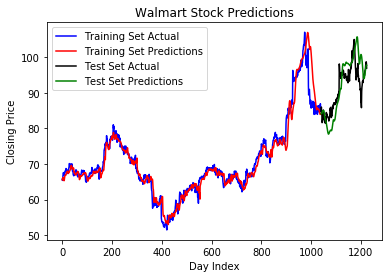

In [27]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

It seems there is a bit of randomness in the training scores (likely due to different starting weights and which variables are dropped in dropout layers during fitting).  They seem to score about the same.  As a simpler network seems to work, we will use it (128, 128, 16).

#### Number of Epochs

We will look at how the number of epochs affects our error.  The inbuilt fit function in keras has a way of doing this.


In [28]:
def see_history(df, seq_length, fut_point, train_split, neurons, dropout, epochs, batch_size, 
                           validation_split, model_path):
    
    #get train/test split
    X_train, X_test, y_train, y_test = train_test_splitter(df, seq_length, fut_point, train_split)
    
    #get number of features
    features = X_train.shape[2]
    
    #get scalers and normalized data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler = create_scalers_and_normalize(
        X_train, X_test, y_train, y_test)
    
    #create model
    model = create_generic_LSTM_model(neurons, dropout, seq_length, features)
    
    #fit model
    history = model.fit(X_train_scaled, y_train_scaled, epochs = epochs, 
              batch_size = batch_size, validation_split = validation_split, verbose = 1)
    
    #save model
    model.save(model_path)
    
    return history

In [29]:
#do so
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [128, 128, 16]
epochs = 750
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'epoch_test.h5'
history = see_history(df, seq_length, fut_point, train_split, neurons, dropout, epochs, batch_size, validation_split,
                     model_path)

Train on 884 samples, validate on 156 samples
Epoch 1/750
884/884 [==============================] - 5s 5ms/step - loss: 0.0487 - acc: 0.0011 - val_loss: 0.2177 - val_acc: 0.0000e+00
Epoch 2/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0108 - acc: 0.0011 - val_loss: 0.2041 - val_acc: 0.0000e+00
Epoch 3/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0076 - acc: 0.0011 - val_loss: 0.2213 - val_acc: 0.0000e+00
Epoch 4/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.2124 - val_acc: 0.0000e+00
Epoch 5/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.2224 - val_acc: 0.0000e+00
Epoch 6/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.2244 - val_acc: 0.0000e+00
Epoch 7/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0060 - acc: 0.0011 - val_loss: 0.2408 - val_acc: 0.0000

884/884 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.2549 - val_acc: 0.0000e+00
Epoch 61/750
884/884 [==============================] - 1s 943us/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.2659 - val_acc: 0.0000e+00
Epoch 62/750
884/884 [==============================] - 1s 966us/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.2801 - val_acc: 0.0000e+00
Epoch 63/750
884/884 [==============================] - 1s 974us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.3044 - val_acc: 0.0000e+00
Epoch 64/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.2723 - val_acc: 0.0000e+00
Epoch 65/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.2764 - val_acc: 0.0000e+00
Epoch 66/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.2507 - val_acc: 0.0000e+00
Epoch 67/750
884/884 [===================

884/884 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.0354 - val_acc: 0.0064
Epoch 120/750
884/884 [==============================] - 1s 999us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0272 - val_acc: 0.0064
Epoch 121/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.0238 - val_acc: 0.0064
Epoch 122/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0250 - val_acc: 0.0064
Epoch 123/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.0384 - val_acc: 0.0064
Epoch 124/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0311 - val_acc: 0.0064
Epoch 125/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0376 - val_acc: 0.0064
Epoch 126/750
884/884 [==============================] - 1s 1ms/ste

884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 180/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0347 - val_acc: 0.0000e+00
Epoch 181/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0246 - val_acc: 0.0064
Epoch 182/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0320 - val_acc: 0.0000e+00
Epoch 183/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0381 - val_acc: 0.0000e+00
Epoch 184/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0272 - val_acc: 0.0064
Epoch 185/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0369 - val_acc: 0.0000e+00
Epoch 186/750
884/884 [==========================

884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0939 - val_acc: 0.0064
Epoch 240/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0391 - val_acc: 0.0064
Epoch 241/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0417 - val_acc: 0.0064
Epoch 242/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0374 - val_acc: 0.0064
Epoch 243/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0759 - val_acc: 0.0064
Epoch 244/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0760 - val_acc: 0.0064
Epoch 245/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0481 - val_acc: 0.0064
Epoch 246/750
884/884 [==============================] - 1s 1ms/step 

Epoch 300/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0563 - val_acc: 0.0064
Epoch 301/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0463 - val_acc: 0.0064
Epoch 302/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0865 - val_acc: 0.0064
Epoch 303/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0845 - val_acc: 0.0064
Epoch 304/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0665 - val_acc: 0.0064
Epoch 305/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0478 - val_acc: 0.0064
Epoch 306/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0462 - val_acc: 0.0064
Epoch 307/750
884/884 [==============================] 

884/884 [==============================] - 1s 1ms/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.0672 - val_acc: 0.0064
Epoch 361/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.0879 - val_acc: 0.0064
Epoch 362/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0530 - val_acc: 0.0064
Epoch 363/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.1088 - val_acc: 0.0064
Epoch 364/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0028 - acc: 0.0011 - val_loss: 0.0852 - val_acc: 0.0064
Epoch 365/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.0875 - val_acc: 0.0064
Epoch 366/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.1504 - val_acc: 0.0064
Epoch 367/750
884/884 [==============================] - 1s 1ms/step 

884/884 [==============================] - 1s 1ms/step - loss: 0.0026 - acc: 0.0011 - val_loss: 0.0445 - val_acc: 0.0064
Epoch 421/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0025 - acc: 0.0011 - val_loss: 0.0935 - val_acc: 0.0064
Epoch 422/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0028 - acc: 0.0011 - val_loss: 0.1053 - val_acc: 0.0064
Epoch 423/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0027 - acc: 0.0011 - val_loss: 0.0670 - val_acc: 0.0000e+00
Epoch 424/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0026 - acc: 0.0011 - val_loss: 0.0596 - val_acc: 0.0000e+00
Epoch 425/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0025 - acc: 0.0011 - val_loss: 0.0628 - val_acc: 0.0064
Epoch 426/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0025 - acc: 0.0011 - val_loss: 0.0496 - val_acc: 0.0064
Epoch 427/750
884/884 [==============================] - 1s 1

884/884 [==============================] - 1s 1ms/step - loss: 0.0021 - acc: 0.0011 - val_loss: 0.0481 - val_acc: 0.0064
Epoch 481/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0021 - acc: 0.0011 - val_loss: 0.0447 - val_acc: 0.0064
Epoch 482/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0021 - acc: 0.0011 - val_loss: 0.0905 - val_acc: 0.0064
Epoch 483/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0021 - acc: 0.0011 - val_loss: 0.1464 - val_acc: 0.0064
Epoch 484/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0021 - acc: 0.0011 - val_loss: 0.0327 - val_acc: 0.0064
Epoch 485/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0019 - acc: 0.0011 - val_loss: 0.0859 - val_acc: 0.0064
Epoch 486/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0020 - acc: 0.0011 - val_loss: 0.1059 - val_acc: 0.0064
Epoch 487/750
884/884 [==============================] - 1s 1ms/step 

Epoch 541/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.0571 - val_acc: 0.0064
Epoch 542/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.0484 - val_acc: 0.0064
Epoch 543/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.0410 - val_acc: 0.0064
Epoch 544/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.0877 - val_acc: 0.0064
Epoch 545/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0019 - acc: 0.0011 - val_loss: 0.0721 - val_acc: 0.0064
Epoch 546/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.0904 - val_acc: 0.0064
Epoch 547/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0784 - val_acc: 0.0064
Epoch 548/750
884/884 [==============================] 

884/884 [==============================] - 1s 1ms/step - loss: 0.0013 - acc: 0.0011 - val_loss: 0.0563 - val_acc: 0.0064
Epoch 602/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0013 - acc: 0.0011 - val_loss: 0.0984 - val_acc: 0.0064
Epoch 603/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0014 - acc: 0.0011 - val_loss: 0.1342 - val_acc: 0.0064
Epoch 604/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0013 - acc: 0.0011 - val_loss: 0.1106 - val_acc: 0.0064
Epoch 605/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0013 - acc: 0.0011 - val_loss: 0.0585 - val_acc: 0.0064
Epoch 606/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0013 - acc: 0.0011 - val_loss: 0.0612 - val_acc: 0.0064
Epoch 607/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0013 - acc: 0.0011 - val_loss: 0.0775 - val_acc: 0.0064
Epoch 608/750
884/884 [==============================] - 1s 1ms/step 

884/884 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.0011 - val_loss: 0.0514 - val_acc: 0.0064
Epoch 662/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.0011 - val_loss: 0.1251 - val_acc: 0.0000e+00
Epoch 663/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.0011 - val_loss: 0.1405 - val_acc: 0.0000e+00
Epoch 664/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0011 - acc: 0.0011 - val_loss: 0.1305 - val_acc: 0.0000e+00
Epoch 665/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0011 - acc: 0.0011 - val_loss: 0.0965 - val_acc: 0.0064
Epoch 666/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.0011 - val_loss: 0.0673 - val_acc: 0.0064
Epoch 667/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.0011 - val_loss: 0.0895 - val_acc: 0.0000e+00
Epoch 668/750
884/884 [==============================

884/884 [==============================] - 1s 1ms/step - loss: 8.5192e-04 - acc: 0.0011 - val_loss: 0.1133 - val_acc: 0.0000e+00
Epoch 720/750
884/884 [==============================] - 1s 1ms/step - loss: 9.0503e-04 - acc: 0.0011 - val_loss: 0.0937 - val_acc: 0.0064
Epoch 721/750
884/884 [==============================] - 1s 1ms/step - loss: 8.1417e-04 - acc: 0.0011 - val_loss: 0.0773 - val_acc: 0.0064
Epoch 722/750
884/884 [==============================] - 1s 1ms/step - loss: 8.7059e-04 - acc: 0.0011 - val_loss: 0.0727 - val_acc: 0.0064
Epoch 723/750
884/884 [==============================] - 1s 1ms/step - loss: 8.3322e-04 - acc: 0.0011 - val_loss: 0.1928 - val_acc: 0.0000e+00
Epoch 724/750
884/884 [==============================] - 1s 1ms/step - loss: 8.8498e-04 - acc: 0.0011 - val_loss: 0.2225 - val_acc: 0.0000e+00
Epoch 725/750
884/884 [==============================] - 1s 1ms/step - loss: 8.7481e-04 - acc: 0.0011 - val_loss: 0.0861 - val_acc: 0.0000e+00
Epoch 726/750
884/884 [==

In [31]:
#loss history by epoch
history.history

{'val_loss': [0.21773967786859244,
  0.2040790221056877,
  0.22132996956889445,
  0.21240177932075965,
  0.2223886466370179,
  0.22437996913989386,
  0.24079938614979768,
  0.2546698502623118,
  0.23038051009942323,
  0.2308641295784559,
  0.24606414750600472,
  0.24976456375458303,
  0.27292584092953265,
  0.2629669033564054,
  0.2592347495448895,
  0.27268831584698117,
  0.2791194201279909,
  0.26932291992199725,
  0.2592453255485266,
  0.24635906995106965,
  0.2407879168406511,
  0.2156013117577785,
  0.26200704677746844,
  0.29046001380834824,
  0.26513622567439693,
  0.27171278324646825,
  0.28213503670233947,
  0.2641317162376184,
  0.2509617331700447,
  0.24109248320261636,
  0.2492522929723446,
  0.27621900939788574,
  0.28133344592956394,
  0.3044768877518483,
  0.30608795487727875,
  0.29841735252203083,
  0.3325141666409297,
  0.3369232662595235,
  0.3085466865927745,
  0.30053871545272,
  0.29048702388237685,
  0.28513279136938924,
  0.2825379404119956,
  0.2809236962825824

We can look at the loss history by reading it into a dataframe.

In [32]:
#read into dataframe
history_df = pd.DataFrame(history.history)

In [33]:
#look at columns
history_df.head()

,val_loss,val_acc,loss,acc
0,0.217740,0.0,0.048656,0.001131
1,0.204079,0.0,0.010816,0.001131
2,0.221330,0.0,0.007631,0.001131
3,0.212402,0.0,0.006587,0.001131
4,0.222389,0.0,0.006236,0.001131


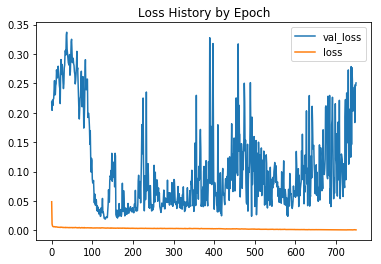

In [34]:
history_df.plot(y = ['val_loss', 'loss'], title = 'Loss History by Epoch')

The loss in general seems to decrease a great deal, but the validation loss is very noisy after about 100 epochs.  We will use 100 epochs going forward.

#### Dropout Amount

Now, we consider dropout amount (percentage of weights dropped in each iteration).

Train on 884 samples, validate on 156 samples
Epoch 1/100
884/884 [==============================] - 5s 5ms/step - loss: 0.0606 - acc: 0.0011 - val_loss: 0.1111 - val_acc: 0.0000e+00
Epoch 2/100
884/884 [==============================] - 1s 886us/step - loss: 0.0119 - acc: 0.0011 - val_loss: 0.0924 - val_acc: 0.0000e+00
Epoch 3/100
884/884 [==============================] - 1s 787us/step - loss: 0.0097 - acc: 0.0011 - val_loss: 0.0843 - val_acc: 0.0000e+00
Epoch 4/100
884/884 [==============================] - 1s 722us/step - loss: 0.0085 - acc: 0.0011 - val_loss: 0.0823 - val_acc: 0.0000e+00
Epoch 5/100
884/884 [==============================] - 1s 910us/step - loss: 0.0079 - acc: 0.0011 - val_loss: 0.0855 - val_acc: 0.0000e+00
Epoch 6/100
884/884 [==============================] - 1s 829us/step - loss: 0.0077 - acc: 0.0011 - val_loss: 0.0900 - val_acc: 0.0000e+00
Epoch 7/100
884/884 [==============================] - 1s 884us/step - loss: 0.0073 - acc: 0.0011 - val_loss: 0.0901 - val

884/884 [==============================] - 1s 720us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0739 - val_acc: 0.0000e+00
Epoch 60/100
884/884 [==============================] - 1s 746us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0822 - val_acc: 0.0000e+00
Epoch 61/100
884/884 [==============================] - 1s 753us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0869 - val_acc: 0.0000e+00
Epoch 62/100
884/884 [==============================] - 1s 823us/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.0883 - val_acc: 0.0000e+00
Epoch 63/100
884/884 [==============================] - 1s 813us/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0913 - val_acc: 0.0000e+00
Epoch 64/100
884/884 [==============================] - 1s 835us/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0859 - val_acc: 0.0000e+00
Epoch 65/100
884/884 [==============================] - 1s 889us/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.0839 - val_acc: 0.0000e+00
Epoch 66/100
884/884 [===========

884/884 [==============================] - 1s 769us/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.1005 - val_acc: 0.0000e+00
Epoch 17/100
884/884 [==============================] - 1s 731us/step - loss: 0.0061 - acc: 0.0011 - val_loss: 0.0941 - val_acc: 0.0000e+00
Epoch 18/100
884/884 [==============================] - 1s 725us/step - loss: 0.0059 - acc: 0.0011 - val_loss: 0.0873 - val_acc: 0.0000e+00
Epoch 19/100
884/884 [==============================] - 1s 729us/step - loss: 0.0058 - acc: 0.0011 - val_loss: 0.0889 - val_acc: 0.0000e+00
Epoch 20/100
884/884 [==============================] - 1s 732us/step - loss: 0.0065 - acc: 0.0011 - val_loss: 0.0891 - val_acc: 0.0000e+00
Epoch 21/100
884/884 [==============================] - 1s 734us/step - loss: 0.0063 - acc: 0.0011 - val_loss: 0.0863 - val_acc: 0.0000e+00
Epoch 22/100
884/884 [==============================] - 1s 729us/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.0897 - val_acc: 0.0000e+00
Epoch 23/100
884/884 [===========

884/884 [==============================] - 1s 838us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 75/100
884/884 [==============================] - 1s 798us/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0731 - val_acc: 0.0000e+00
Epoch 76/100
884/884 [==============================] - 1s 747us/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0854 - val_acc: 0.0000e+00
Epoch 77/100
884/884 [==============================] - 1s 729us/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0868 - val_acc: 0.0000e+00
Epoch 78/100
884/884 [==============================] - 1s 762us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0951 - val_acc: 0.0000e+00
Epoch 79/100
884/884 [==============================] - 1s 757us/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.0840 - val_acc: 0.0000e+00
Epoch 80/100
884/884 [==============================] - 1s 889us/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.0768 - val_acc: 0.0000e+00
Epoch 81/100
884/884 [===========

884/884 [==============================] - 1s 727us/step - loss: 0.0059 - acc: 0.0011 - val_loss: 0.0930 - val_acc: 0.0000e+00
Epoch 32/100
884/884 [==============================] - 1s 739us/step - loss: 0.0063 - acc: 0.0011 - val_loss: 0.0905 - val_acc: 0.0000e+00
Epoch 33/100
884/884 [==============================] - 1s 723us/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.0915 - val_acc: 0.0000e+00
Epoch 34/100
884/884 [==============================] - 1s 740us/step - loss: 0.0057 - acc: 0.0011 - val_loss: 0.0906 - val_acc: 0.0000e+00
Epoch 35/100
884/884 [==============================] - 1s 727us/step - loss: 0.0057 - acc: 0.0011 - val_loss: 0.0859 - val_acc: 0.0000e+00
Epoch 36/100
884/884 [==============================] - 1s 725us/step - loss: 0.0055 - acc: 0.0011 - val_loss: 0.0818 - val_acc: 0.0000e+00
Epoch 37/100
884/884 [==============================] - 1s 731us/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.0845 - val_acc: 0.0000e+00
Epoch 38/100
884/884 [===========

884/884 [==============================] - 1s 691us/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.1108 - val_acc: 0.0000e+00
Epoch 90/100
884/884 [==============================] - 1s 736us/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.1073 - val_acc: 0.0000e+00
Epoch 91/100
884/884 [==============================] - 1s 738us/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0950 - val_acc: 0.0000e+00
Epoch 92/100
884/884 [==============================] - 1s 754us/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.1119 - val_acc: 0.0000e+00
Epoch 93/100
884/884 [==============================] - 1s 740us/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.1302 - val_acc: 0.0000e+00
Epoch 94/100
884/884 [==============================] - 1s 737us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1265 - val_acc: 0.0000e+00
Epoch 95/100
884/884 [==============================] - 1s 739us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1035 - val_acc: 0.0000e+00
Epoch 96/100
884/884 [===========

884/884 [==============================] - 1s 861us/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1422 - val_acc: 0.0000e+00
Epoch 47/100
884/884 [==============================] - 1s 895us/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.1375 - val_acc: 0.0000e+00
Epoch 48/100
884/884 [==============================] - 1s 721us/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.1349 - val_acc: 0.0000e+00
Epoch 49/100
884/884 [==============================] - 1s 736us/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.1370 - val_acc: 0.0000e+00
Epoch 50/100
884/884 [==============================] - 1s 754us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.1444 - val_acc: 0.0000e+00
Epoch 51/100
884/884 [==============================] - 1s 736us/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.1475 - val_acc: 0.0000e+00
Epoch 52/100
884/884 [==============================] - 1s 758us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.1407 - val_acc: 0.0000e+00
Epoch 53/100
884/884 [===========

884/884 [==============================] - 1s 675us/step - loss: 0.0099 - acc: 0.0011 - val_loss: 0.1151 - val_acc: 0.0000e+00
Epoch 4/100
884/884 [==============================] - 1s 771us/step - loss: 0.0088 - acc: 0.0011 - val_loss: 0.1189 - val_acc: 0.0000e+00
Epoch 5/100
884/884 [==============================] - 1s 775us/step - loss: 0.0081 - acc: 0.0011 - val_loss: 0.1277 - val_acc: 0.0000e+00
Epoch 6/100
884/884 [==============================] - 1s 758us/step - loss: 0.0071 - acc: 0.0011 - val_loss: 0.1266 - val_acc: 0.0000e+00
Epoch 7/100
884/884 [==============================] - 1s 898us/step - loss: 0.0072 - acc: 0.0011 - val_loss: 0.1260 - val_acc: 0.0000e+00
Epoch 8/100
884/884 [==============================] - 1s 716us/step - loss: 0.0068 - acc: 0.0011 - val_loss: 0.1286 - val_acc: 0.0000e+00
Epoch 9/100
884/884 [==============================] - 1s 760us/step - loss: 0.0071 - acc: 0.0011 - val_loss: 0.1326 - val_acc: 0.0000e+00
Epoch 10/100
884/884 [=================

884/884 [==============================] - 1s 768us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0903 - val_acc: 0.0000e+00
Epoch 62/100
884/884 [==============================] - 1s 746us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0806 - val_acc: 0.0000e+00
Epoch 63/100
884/884 [==============================] - 1s 767us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0741 - val_acc: 0.0000e+00
Epoch 64/100
884/884 [==============================] - 1s 757us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0811 - val_acc: 0.0000e+00
Epoch 65/100
884/884 [==============================] - 1s 738us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0855 - val_acc: 0.0000e+00
Epoch 66/100
884/884 [==============================] - 1s 739us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0814 - val_acc: 0.0000e+00
Epoch 67/100
884/884 [==============================] - 1s 734us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0786 - val_acc: 0.0000e+00
Epoch 68/100
884/884 [===========

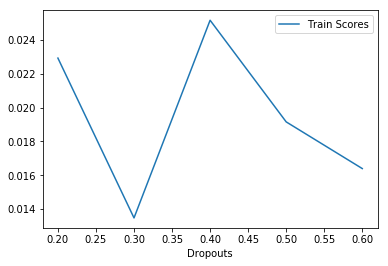

In [35]:
#look at dropout
#use training score as metric (should really only score on test set when done.)
#set up parameters
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [128, 128, 16]
epochs = 100
batch_size = 64
validation_split = 0.15
model_path = 'dummy_path.h5'

#set up variances of neuron size
dropout_list = [0.2, 0.3, 0.4, 0.5, 0.6]

#create lists to store results
dropouts = []
train_scores = []

#iterate
for dropout in dropout_list:
    dropouts.append(dropout)
    
    train, test, train_preds, test_preds, train_score, test_score = fit_generic_LSTM_model(df, seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neuron_length, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)
    
    train_scores.append(train_score[0])
    
#create dataframe
results = pd.DataFrame({'Dropouts': dropouts, 'Train Scores': train_scores})

results.plot(x = 'Dropouts', y = 'Train Scores')

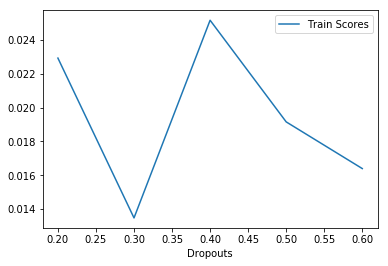

In [36]:
#plot results
results.plot(x = 'Dropouts', y = 'Train Scores')

We see that the dropout value of 0.30 is best.